In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
## combine data from all different years into a  single year
csv = [pd.read_csv(f"./data/N_{str(i).zfill(2)}_extent_v3.0.csv") for i in range(1, 13)]
ice = pd.concat(csv, axis=0, ignore_index=True)
columns = ice.columns
name = [col.strip() for col in columns]
ice.columns = name
ice['extent'] = np.where(abs(ice['extent']) > 20 , np.nan, ice['extent'])
ice['area'] = np.where(abs(ice['area']) > 20, np.nan, ice['area'])
ice.interpolate(inplace=True)

C:\Users\ahmed\AppData\Local\Temp\ipykernel_11072\592835662.py:9: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ice.interpolate(inplace=True)


## Monthly graph

In [3]:
filtered_df = ice[(ice['year'] == 2021) | (ice['year'] == 2022)]
sorted_df = filtered_df.sort_values(by=['year', 'mo'])

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
years = ["2021", "2022"]

# Create an array of strings using a list comprehension
date_strings = [f"{month} {year}" for year in years for month in months]

# Convert the list to a NumPy array
np_array_of_strings = np.array(date_strings)

sorted_df["label"] = np_array_of_strings

sorted_df.head()

,year,mo,data-type,region,extent,area,label
42,2021,1,Goddard,N,13.50,11.75,Jan 2021
87,2021,2,Goddard,N,14.39,12.76,Feb 2021
132,2021,3,Goddard,N,14.66,12.99,Mar 2021
177,2021,4,Goddard,N,13.79,12.18,Apr 2021
222,2021,5,Goddard,N,12.68,10.86,May 2021


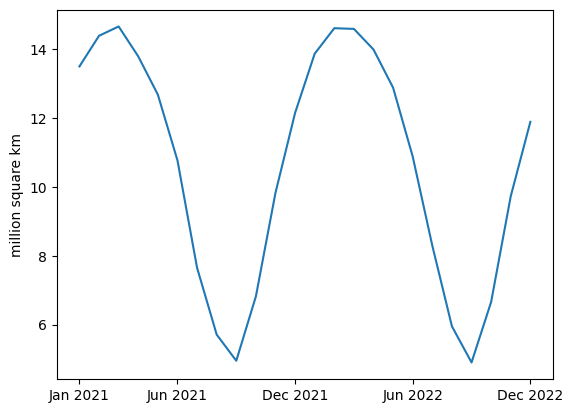

In [4]:
plt.plot(sorted_df['label'], sorted_df['extent'])

plt.xticks([0, 5, 11, 17, 23], sorted_df['label'].iloc[[0, 5, 11, 17, 23]])
plt.ylabel("million square km")
plt.show()

## Yearly mean graph

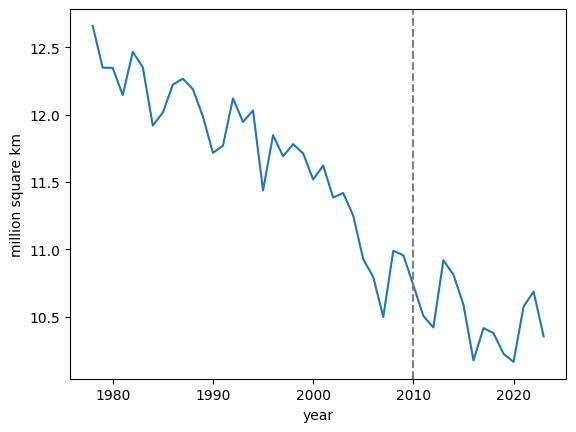

In [5]:
yearly_mean = ice.groupby('year')[['extent']].mean().reset_index()

plt.plot(yearly_mean["year"],yearly_mean["extent"])
plt.xlabel("year")
plt.ylabel("million square km")

# showing the test set
plt.axvline(x=2010, linestyle='--', color='gray', label='Horizontal Line at x=2010')

plt.show()

In [6]:
# measure yearly rate of change

# Calculate the rate of change
first_extent = yearly_mean['extent'].iloc[0]
last_extent = yearly_mean['extent'].iloc[-1]

rate_of_change = ((last_extent - first_extent) / len(yearly_mean['extent'])) * 10

print(f"The rate of change of Arctic ice extent over the entire time period is: {rate_of_change:.2f}%")

The rate of change of Arctic ice extent over the entire time period is: -0.50%


## train test split
Use the last 30% of the years for testing

In [7]:
from sklearn.model_selection import train_test_split
x = yearly_mean[['year']]
y=yearly_mean[['extent']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1,shuffle = False)

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

## Performance metrics

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_model(y_test, y_pred):

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error: {mae}')

## Linear regression

In [20]:
import numpy as np

def linear_regression(x_train, y_train, x_test):
    # Add a column of ones to the input data for the intercept term
    x_train = np.column_stack((np.ones_like(x_train), x_train))
    x_test = np.column_stack((np.ones_like(x_test), x_test))

    # Calculate the coefficients using the normal equation
    coefficients = np.linalg.inv(x_train.T @ x_train) @ x_train.T @ y_train

    # Predict the values for the test set
    y_pred = x_test @ coefficients

    return y_pred

# Perform linear regression
y_pred = linear_regression(x_train, y_train, x_test)

# Print the coefficients
# print("Coefficients:", y_pred)

evaluate_model(y_test, y_pred)

Mean Squared Error: 0.06277197923338117
Mean Absolute Error: 0.22208534619325931


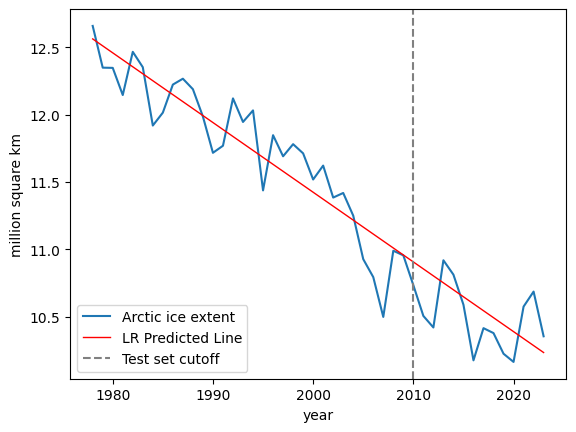

In [21]:
plt.plot(yearly_mean["year"],yearly_mean["extent"], label="Arctic ice extent")
plt.xlabel("year")
plt.ylabel("million square km")

train_test_x = np.concatenate((x_train, x_test), axis=0)

y_pred = linear_regression(x_train, y_train, train_test_x)
plt.plot(train_test_x, y_pred, color='red', linewidth=1, label='LR Predicted Line')

# y_pred = svr.predict(train_test_x)
# plt.plot(train_test_x, y_pred, color='green', linewidth=1, label='SVR Predicted Line')

# y_pred = poly_regression_model.predict(poly_train_test_x)
# plt.plot(train_test_x, y_pred, color='purple', linewidth=1, label='PR Predicted Line')

# showing the test set
plt.axvline(x=2010, linestyle='--', color='gray', label='Test set cutoff')

plt.legend()

plt.show()